# Data Science Research Project A - Free Space Optical Communication Channel Model
## 1. Data Loading and preprocesing

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Set random seed
seed = 22
np.random.seed(seed)
random.seed(seed)

# Set display options to avoid line wrapping
pd.set_option('display.expand_frame_repr', False) 

file_path = 'RFLFSODataFull.csv'  
data = pd.read_csv(file_path)

print("data info:")
print(data.info())
print("\ndata head:")
print(data.head())
print("\ndata distribution:")
print(data.describe())

X = data.drop(columns=['RFL_Att', 'FSO_Att'])
y = data['FSO_Att']

# Split the dataset by weather condition levels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22, stratify=data['SYNOPCode'])

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int6


 SYNOPCode count:
0    56964
6    25018
5     6605
8     1716
4      466
7      419
3      191
Name: SYNOPCode, dtype: int64


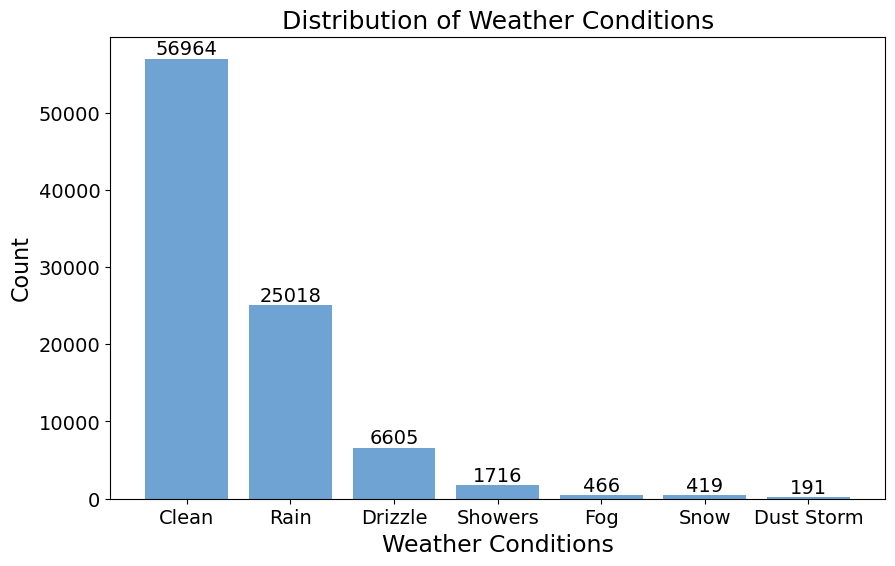

In [2]:
# Print SYNOPCode count
print("\n SYNOPCode count:")
synop_counts = data['SYNOPCode'].value_counts()
print(synop_counts)

# Mapping from SYNOPCode to weather labels
weather_labels = {
    0: 'Clean',
    6: 'Rain',
    5: 'Drizzle',
    8: 'Showers',
    4: 'Fog',
    7: 'Snow',
    3: 'Dust Storm'
}

# Reindex and map weather labels
synop_counts = synop_counts.rename(index=weather_labels)

# Data visualisation
plt.figure(figsize=(10, 6))
bars = plt.bar(synop_counts.index, synop_counts.values, color='#6FA3D3')
plt.title('Distribution of Weather Conditions', fontsize=18)
plt.xlabel('Weather Conditions', fontsize=17)
plt.ylabel('Count', fontsize=16)

# Display count value on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(int(bar.get_height())), ha='center', va='bottom', fontsize=14)

# Set axis tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## 2. Method 1. Generic Random Forest model
### 2.1 Feature selection

In [ ]:
def feature_selection_generic(X_train, y_train, target_variable):
    print("\nProcessing Generic Model")
    
    # One-hot encode the SYNOPCode feature
    X_train = pd.get_dummies(X_train, columns=['SYNOPCode'], drop_first=True)

    # Initialize result lists
    results = []
    removed_features = []
    ordered_features = []  # List to store the remaining features
    last_removed_feature = None  # To store the last removed feature

    # Feature selection process
    iteration = 1  # Initialize iteration counter
    while X_train.shape[1] > 0:
        # Define the random forest model and use OOB score
        rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=22)
        rf.fit(X_train, y_train)

        # Get feature importances
        importances = rf.feature_importances_
        least_important_feature_index = np.argmin(importances)

        # Calculate OOB RMSE and R² for the current model
        oob_pred = rf.oob_prediction_
        rmse = mean_squared_error(y_train, oob_pred, squared=False)
        r2 = r2_score(y_train, oob_pred)

        # Store results
        results.append((rmse, r2))
        least_important_feature = X_train.columns[least_important_feature_index]
        removed_features.append(least_important_feature)

        # Print the current model's performance with 4 decimal places
        print(f"Iteration {iteration}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

        # Print the number of remaining features based on the iteration
        if iteration == 1:
            print(f"Remaining features: {X_train.shape[1]}")  
        else:
            print(f"Removed feature: {last_removed_feature}. Remaining features: {X_train.shape[1]}") 
            
        last_removed_feature = least_important_feature 

        # Drop the least important feature
        X_train = X_train.drop(columns=[least_important_feature])

        # Add to ordered_features list
        ordered_features.append(least_important_feature)

        iteration += 1  # Increment iteration counter

    # Add the last remaining feature
    if X_train.shape[1] > 0:
        ordered_features.append(X_train.columns[0])  

    # Extract RMSE and R² values
    rmse_values = [result[0] for result in results]
    r2_values = [result[1] for result in results]

    # Plot line charts
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot RMSE line chart
    ax1.set_xlabel('Removed Features', fontsize=14) 
    ax1.set_ylabel('RMSE(dB)', color='tab:red', fontsize=14)  
    ax1.plot(range(len(rmse_values)), rmse_values, color='tab:red', marker='o', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create second y-axis to plot R² line chart
    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:blue', fontsize=14) 
    ax2.plot(range(len(r2_values)), r2_values, color='tab:blue', marker='o', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis ticks and labels
    ax1.set_xticks(range(len(rmse_values)))
    ax1.set_xticklabels(ordered_features, rotation=45, ha='right', fontsize=12) 
    # Add title and legend
    plt.title(f'Generic Model Performance for {target_variable} Attenuation', fontsize=16)
    fig.tight_layout() 
    plt.show()

    # Return the ordered_features list
    return ordered_features


Processing Generic Model
Iteration 1: RMSE = 0.8826, R² = 0.9490
Remaining features: 30
Iteration 2: RMSE = 0.8836, R² = 0.9488
Removed feature: SYNOPCode_4. Remaining features: 29
Iteration 3: RMSE = 0.8834, R² = 0.9489
Removed feature: SYNOPCode_8. Remaining features: 28
Iteration 4: RMSE = 0.8800, R² = 0.9492
Removed feature: SYNOPCode_7. Remaining features: 27
Iteration 5: RMSE = 0.8823, R² = 0.9490
Removed feature: Frequency. Remaining features: 26
Iteration 6: RMSE = 0.8831, R² = 0.9489
Removed feature: SYNOPCode_6. Remaining features: 25
Iteration 7: RMSE = 0.8812, R² = 0.9491
Removed feature: SYNOPCode_5. Remaining features: 24
Iteration 8: RMSE = 0.8831, R² = 0.9489
Removed feature: RainIntensityMax. Remaining features: 23
Iteration 9: RMSE = 0.8800, R² = 0.9492
Removed feature: RainIntensityMin. Remaining features: 22
Iteration 10: RMSE = 0.8703, R² = 0.9504
Removed feature: WindDirection. Remaining features: 21
Iteration 11: RMSE = 0.8693, R² = 0.9505
Removed feature: RainI

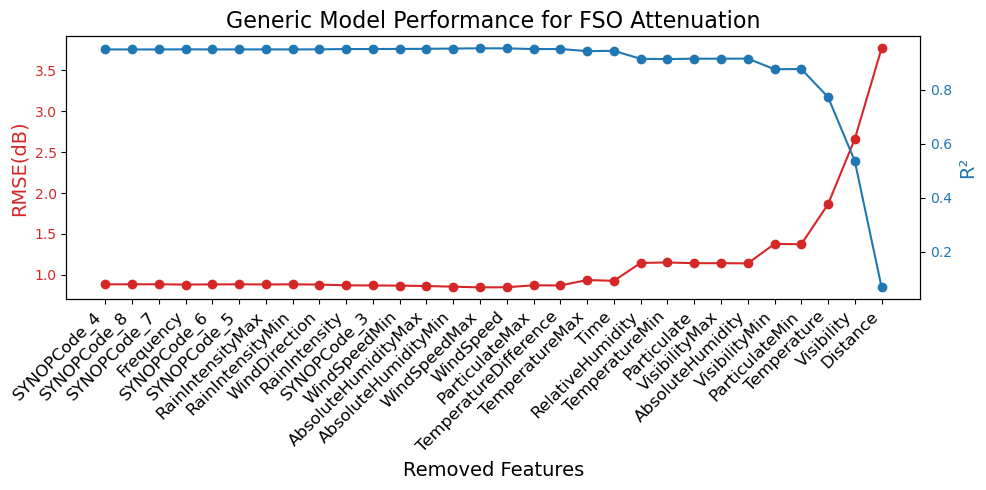

In [4]:
generic_ordered_feature = feature_selection_generic(X_train, y_train, "FSO")

In [5]:
generic_selected_features = generic_ordered_feature[-13:] 
print(generic_selected_features)

['TemperatureDifference', 'TemperatureMax', 'Time', 'RelativeHumidity', 'TemperatureMin', 'Particulate', 'VisibilityMax', 'AbsoluteHumidity', 'VisibilityMin', 'ParticulateMin', 'Temperature', 'Visibility', 'Distance']


### 2.2 Hyperparameter optimisation

In [6]:
def tune_hyperparameters(X_train, y_train, selected_features):
    
    # Train using the passed selected features
    X_train_selected = X_train[selected_features]
    
    # Define the random forest model
    rf = RandomForestRegressor(oob_score=True, random_state=22)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [None, 10, 20]
    }
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    # Get the best hyperparameter combination
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

In [7]:
# Use the 13 most important features for hyperparameter tuning
best_params = tune_hyperparameters(X_train, y_train, generic_selected_features)

/Users/elise/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'n_estimators': 200}


### 2.3 Train and evalute the generic RF model with the best hyperparameter values

In [ ]:
# Weather condition mapping
condition_map = {
    0: 'Clear',
    3: 'Dust Storm',
    4: 'Fog',
    5: 'Drizzle',
    6: 'Rain',
    7: 'Snow',
    8: 'Showers'
}

In [ ]:
def train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, selected_features, best_params):
   
    # Train using the selected features passed in
    X_train_copy = X_train.copy()  # Start with selected features (make a copy)
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Define the model using the best hyperparameter combination
    generic_RF_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        oob_score=True,
        random_state=22
    )

    # Train the model on the training set
    generic_RF_model.fit(X_train_selected, y_train)
    
    # Make predictions on the training set
    y_train_pred = generic_RF_model.predict(X_train_selected)

    # Calculate RMSE and R² for the training set
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)

    # Make predictions on the test set
    y_test_pred = generic_RF_model.predict(X_test_selected)
    
    # Calculate RMSE and R² for the test set
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)
    
    # OOB evaluation
    oob_rmse = mean_squared_error(y_train, generic_RF_model.oob_prediction_, squared=False)
    oob_r2 = r2_score(y_train, generic_RF_model.oob_prediction_)

    # Add RFL_Att_pred to the original dataset
    data.loc[X_train.index, 'FSO_Att_pred'] = y_train_pred  

    # Add RFL_Att_pred to the copied dataset (X_train_copy) 
    X_train_copy['FSO_Att_pred'] = y_train_pred  
    
    # Print the results for the training and test sets
    print(f"Training RMSE of generic RF model: {train_rmse:.4f}")
    print(f"Training R² of generic RF model: {train_r2:.4f}")
    print(f"OOB RMSE of generic RF model: {oob_rmse:.4f}")
    print(f"OOB R² of generic RF model: {oob_r2:.4f}")
    print(f"Test RMSE of generic RF model: {rmse_test:.4f}")
    print(f"Test R² of generic RF model: {r2_test:.4f}")

    
    # Store predictions and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    
    # Iterate over X_test
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred[X_test.index.get_loc(index)])  
            actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])  

    # Calculate RMSE and R² for each weather condition
    gene_condition_results = {}
    
    # Weather condition mapping
    condition_map = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Showers'
    }
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            gene_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f' Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return rmse_test, r2_test, gene_condition_results, generic_RF_model, X_train_copy

In [9]:
# Train the generic model with the best parameters
rmse_test, r2_test, gene_condition_results, generic_RF_model, X_train_copy = train_and_evaluate_best_generic_rf_model(X_train, y_train, X_test, y_test, generic_selected_features, best_params)

Training RMSE of generic RF model: 0.3089
Training R² of generic RF model: 0.9937
OOB RMSE of generic RF model: 0.8354
OOB R² of generic RF model: 0.9543
Test RMSE of generic RF model: 0.8051
Test R² of generic RF model: 0.9573
 Weather condition Clear: RMSE = 0.8054, R² = 0.9468
 Weather condition Dust Storm: RMSE = 1.4144, R² = 0.9698
 Weather condition Fog: RMSE = 0.7226, R² = 0.9733
 Weather condition Drizzle: RMSE = 0.7692, R² = 0.9521
 Weather condition Rain: RMSE = 0.7904, R² = 0.9663
 Weather condition Snow: RMSE = 0.9415, R² = 0.9662
 Weather condition Showers: RMSE = 1.0095, R² = 0.9428


From the hyperpararmeter tuning in generic model, we find the best hyperparameters are: {'max_depth': None, 'n_estimators': 200}. So we will use it as the model structure.

# Part B. RF model

## 1. Update the target variable and Feature Selection


Processing Generic Model
Iteration 1: RMSE = 0.5393, R² = 0.9753
Remaining features: 31
Iteration 2: RMSE = 0.5374, R² = 0.9755
Removed feature: SYNOPCode_4. Remaining features: 30
Iteration 3: RMSE = 0.5380, R² = 0.9755
Removed feature: SYNOPCode_7. Remaining features: 29
Iteration 4: RMSE = 0.5378, R² = 0.9755
Removed feature: SYNOPCode_3. Remaining features: 28
Iteration 5: RMSE = 0.5399, R² = 0.9753
Removed feature: SYNOPCode_6. Remaining features: 27
Iteration 6: RMSE = 0.5438, R² = 0.9749
Removed feature: SYNOPCode_5. Remaining features: 26
Iteration 7: RMSE = 0.5392, R² = 0.9753
Removed feature: SYNOPCode_8. Remaining features: 25
Iteration 8: RMSE = 0.5377, R² = 0.9755
Removed feature: WindDirection. Remaining features: 24
Iteration 9: RMSE = 0.5296, R² = 0.9762
Removed feature: WindSpeedMin. Remaining features: 23
Iteration 10: RMSE = 0.5329, R² = 0.9759
Removed feature: WindSpeedMax. Remaining features: 22
Iteration 11: RMSE = 0.5353, R² = 0.9757
Removed feature: Particulate

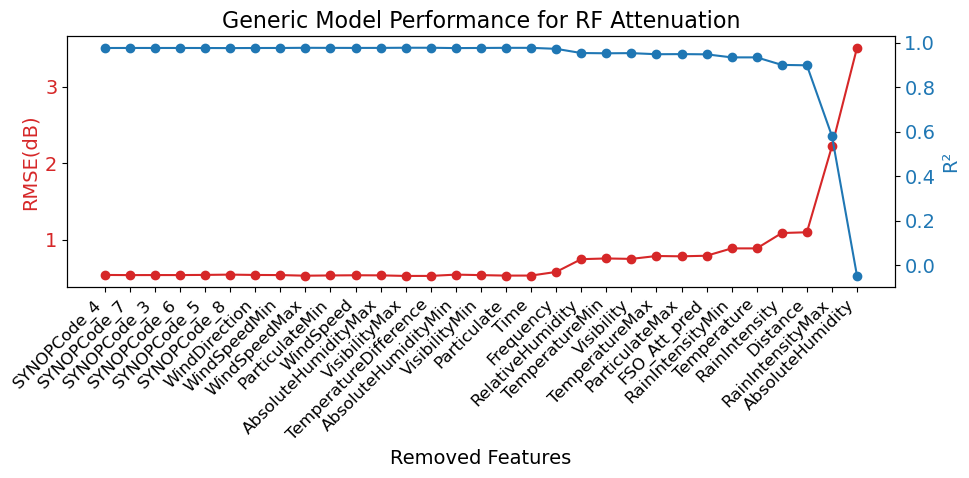

In [ ]:
# Update the target variable y to 'RFL_Att'
y_train_updated = data.loc[X_train_copy.index, 'RFL_Att']  
# y_test_updated = data.loc[X_test.index, 'RFL_Att']

# Perform feature selection to get the ordered feature list
ordered_features = feature_selection_generic(X_train_copy, y_train_updated, "RF")

In [41]:
# Manually choose the number of features to keep
n_selected_features = 14

# Select the top n_selected_features
selected_features_for_rf = ordered_features[-n_selected_features:]

# Update X using the newly selected features
X_train_updated = X_train_copy[selected_features_for_rf]

## 2. Hyperparameter Optimisation and Modelling

In [42]:
# Use the tune_hyperparameters function to tune hyperparameters
best_params = tune_hyperparameters(X_train_updated, y_train_updated, selected_features_for_rf)

# Define the model with the best hyperparameters
rf_model_tuned = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=22,
    oob_score=True
)

# Train the model
rf_model_tuned.fit(X_train_updated, y_train_updated)

# Make predictions
y_train_pred_rf_tuned = rf_model_tuned.predict(X_train_updated)

# Calculate RMSE and R² for the training set
train_rmse_rf_tuned = mean_squared_error(y_train_updated, y_train_pred_rf_tuned, squared=False)
train_r2_rf_tuned = r2_score(y_train_updated, y_train_pred_rf_tuned)

# Print training results
print(f"Training RMSE for tuned RFL_Att prediction (using training set): {train_rmse_rf_tuned:.4f}")
print(f"Training R² for tuned RFL_Att prediction (using training set): {train_r2_rf_tuned:.4f}")

/Users/elise/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'n_estimators': 200}
Training RMSE for tuned RFL_Att prediction (using training set): 0.1923
Training R² for tuned RFL_Att prediction (using training set): 0.9969


## 3. Evaluate the models performance on the test set

In [ ]:
# Second phase: Testing phase for the models on test set

# Step 1: Use generic_RF_model to predict FSO_Att_pred on test set
def test_generic_fso_model(X_test, y_test, generic_RF_model, data):
    
    # Store predictions and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    
    # Ensure that FSO_Att_pred is added to X_test
    X_test_updated = X_test[generic_selected_features]  
    
    # Predict the FSO_Att_pred values on the test set
    y_test_pred_fso = generic_RF_model.predict(X_test_updated)  

    # Add the predicted values to the original dataset
    data.loc[X_test.index, 'FSO_Att_pred'] = y_test_pred_fso  
    
    # Ensure FSO_Att_pred is added to X_test (this is crucial)
    X_test['FSO_Att_pred'] = data.loc[X_test.index, 'FSO_Att_pred']  

    # Calculate RMSE and R² for the test set
    test_rmse_fso = mean_squared_error(y_test, y_test_pred_fso, squared=False)
    test_r2_fso = r2_score(y_test, y_test_pred_fso)

    print(f"Test RMSE of generic FSO model: {test_rmse_fso:.4f}")
    print(f"Test R² of generic FSO model: {test_r2_fso:.4f}")
    
    # Iterate over X_test and classify by SYNOPCode
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred_fso[X_test.index.get_loc(index)])  
            actual_values[condition].append(y_test.iloc[X_test.index.get_loc(index)])  

    # Calculate RMSE and R² for each weather condition
    fso_condition_results = {}
    
    # Weather condition mapping
    condition_map = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Showers'
    }
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            fso_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f' Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return y_test_pred_fso, test_rmse_fso, test_r2_fso, fso_condition_results

# Perform testing using the generic RF model
y_test_pred_fso, test_rmse_fso, test_r2_fso, fso_condition_results = test_generic_fso_model(X_test, y_test, generic_RF_model, data)

# Step 2: Use rf_model_tuned to predict RF_Att_pred on test set
def test_rf_model(X_test, y_test, rf_model_tuned, data):
    
    # Store predictions and actual values by condition
    condition_predictions = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    actual_values = {0: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
    
    X_test_copy = X_test.copy() 
    
    # Ensure that FSO_Att_pred is added to X_test
    X_test_updated = X_test[selected_features_for_rf]  
    
    # Update the target variable y to 'RFL_Att'
    y_test_updated = data.loc[X_test.index, 'RFL_Att']  

    # Make predictions for RFL_Att
    y_test_pred_rf = rf_model_tuned.predict(X_test_updated)

    # Calculate RMSE and R² for the RFL_Att predictions
    test_rmse_rf = mean_squared_error(y_test_updated, y_test_pred_rf, squared=False)
    test_r2_rf = r2_score(y_test_updated, y_test_pred_rf)
    
    # Add RF_Att_pred to the original dataset
    data.loc[X_test.index, 'RF_Att_pred'] = y_test_pred_rf 

    # Add RF_Att_pred to the copied dataset (X_train_copy) 
    X_test_copy['RF_Att_pred'] = y_test_pred_rf 

    print(f"Test RMSE for tuned RFL_Att prediction: {test_rmse_rf:.4f}")
    print(f"Test R² for tuned RFL_Att prediction: {test_r2_rf:.4f}")
    
    # Iterate over X_test and classify by SYNOPCode
    for index, row in X_test.iterrows():
        condition = row['SYNOPCode']
        if condition in condition_predictions:
            condition_predictions[condition].append(y_test_pred_rf[X_test.index.get_loc(index)])  
            actual_values[condition].append(y_test_updated.iloc[X_test.index.get_loc(index)])  

    # Calculate RMSE and R² for each weather condition
    rf_condition_results = {}
    
    # Weather condition mapping
    condition_map = {
        0: 'Clear',
        3: 'Dust Storm',
        4: 'Fog',
        5: 'Drizzle',
        6: 'Rain',
        7: 'Snow',
        8: 'Showers'
    }
    
    for condition in condition_predictions.keys():
        if condition_predictions[condition]:  
            rmse = np.sqrt(mean_squared_error(actual_values[condition], condition_predictions[condition]))
            r2 = r2_score(actual_values[condition], condition_predictions[condition])
            
            # Store RMSE and R² in the dictionary
            rf_condition_results[condition_map[condition]] = {
                'RMSE': rmse,
                'R²': r2
            }

            # Print the results
            print(f' Weather condition {condition_map[condition]}: RMSE = {rmse:.4f}, R² = {r2:.4f}')

    return y_test_pred_rf, test_rmse_rf, test_r2_rf, X_test_copy, rf_condition_results

# Perform testing using the tuned FSO model
y_test_pred_rf, test_rmse_rf, test_r2_rf, X_test_copy, rf_condition_results = test_rf_model(X_test, y_test, rf_model_tuned, data)

data.loc[X_test.index, 'FSO_Att_pred'] = y_test_pred_fso  # Save FSO_Att_pred for test set
data.loc[X_test.index, 'RF_Att_pred'] = y_test_pred_rf  # Save RF_Att_pred for test set

# Display the results
print("\nFinal Results on Test Set:")
print(f"Generic FSO Model - Test RMSE: {test_rmse_fso:.4f}, Test R²: {test_r2_fso:.4f}")
print(f"RFL Model - Test RMSE: {test_rmse_rf:.4f}, Test R²: {test_r2_rf:.4f}")

Test RMSE of generic RF model: 0.8051
Test R² of generic RF model: 0.9573
 Weather condition Clear: RMSE = 0.8054, R² = 0.9468
 Weather condition Dust Storm: RMSE = 1.4144, R² = 0.9698
 Weather condition Fog: RMSE = 0.7226, R² = 0.9733
 Weather condition Drizzle: RMSE = 0.7692, R² = 0.9521
 Weather condition Rain: RMSE = 0.7904, R² = 0.9663
 Weather condition Snow: RMSE = 0.9415, R² = 0.9662
 Weather condition Showers: RMSE = 1.0095, R² = 0.9428
Test RMSE for tuned RFL_Att prediction: 0.4931
Test R² for tuned RFL_Att prediction: 0.9796
 Weather condition Clear: RMSE = 0.3150, R² = 0.9847
 Weather condition Dust Storm: RMSE = 0.2783, R² = 0.9912
 Weather condition Fog: RMSE = 0.2353, R² = 0.9780
 Weather condition Drizzle: RMSE = 0.4615, R² = 0.9740
 Weather condition Rain: RMSE = 0.7342, R² = 0.9678
 Weather condition Snow: RMSE = 0.3397, R² = 0.9376
 Weather condition Showers: RMSE = 0.9612, R² = 0.9067

Final Results on Test Set:
Generic FSO Model - Test RMSE: 0.8051, Test R²: 0.9573

In [45]:
X_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27414 entries, 78254 to 85568
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AbsoluteHumidity       27414 non-null  float64
 1   AbsoluteHumidityMax    27414 non-null  float64
 2   AbsoluteHumidityMin    27414 non-null  float64
 3   Distance               27414 non-null  float64
 4   Frequency              27414 non-null  int64  
 5   Particulate            27414 non-null  float64
 6   ParticulateMax         27414 non-null  float64
 7   ParticulateMin         27414 non-null  float64
 8   RainIntensity          27414 non-null  float64
 9   RainIntensityMax       27414 non-null  float64
 10  RainIntensityMin       27414 non-null  float64
 11  RelativeHumidity       27414 non-null  float64
 12  SYNOPCode              27414 non-null  int64  
 13  Temperature            27414 non-null  float64
 14  TemperatureDifference  27414 non-null  float64
 15

In [46]:
# Find the corresponding actual y values from the original dataset based on the indices of X_test_copy
y_test_RFL = data.loc[X_test_copy.index, 'RFL_Att']
y_test_FSO = data.loc[X_test_copy.index, 'FSO_Att']
y_test_RFL.info()

<class 'pandas.core.series.Series'>
Int64Index: 27414 entries, 78254 to 85568
Series name: RFL_Att
Non-Null Count  Dtype  
--------------  -----  
27414 non-null  float64
dtypes: float64(1)
memory usage: 428.3 KB


In [48]:
y_test_FSO

78254     6.016464
79643     8.738037
15930     7.045450
75588    12.903929
33978     5.589637
           ...    
32185     4.237412
75815     8.346267
82919     7.511418
37593    14.513886
85568    15.369566
Name: FSO_Att, Length: 27414, dtype: float64

In [49]:
# Ensure the two datasets have the same index order
print(X_test_copy.index.equals(y_test_RFL.index))  
print(X_test_copy.index.equals(y_test_FSO.index)) 

True
True


In [50]:
# Merge X_test_copy、y_test_RFL and y_test_FSO
FSO_RF_testset = pd.concat([X_test_copy, y_test_RFL, y_test_FSO], axis=1)
FSO_RF_testset.to_csv("FSO_RF_testset.csv", index=False)